In [20]:
import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

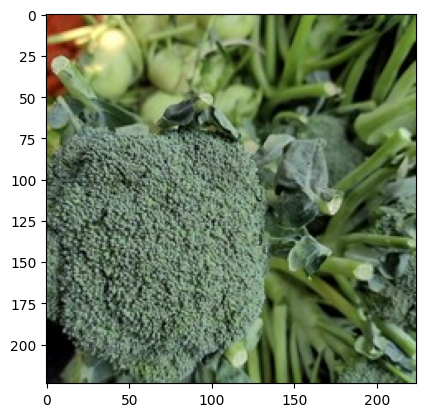

In [21]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Broccoli/1002.jpg', 'r')

imshow(np.asarray(pil_im))

In [22]:
from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
validation_data_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
test_data_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
image_size = (150, 150)
batch_size = 32

In [23]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


# **Image Augmentation**

In [5]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        rotation_range=15,
#        zoom_range=0.1
#)

#validation_datagen = ImageDataGenerator(
#        rescale=1./255
#)


#train_ds_augmentation = train_datagen.flow_from_directory(
#    train_data_dir,
#    #validation_split=0.2,
#    #subset="training",
#    #seed=1337,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)

#validation_ds_augmentation = validation_datagen.flow_from_directory(
#    validation_data_dir,
#    #validation_split=0.2,
#    #subset="validation",
#    #seed=1337,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)

# **The Model**

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    
"""
# MODEL --------------------------------------------------
"""

model = Sequential()
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))

#model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(15, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 35, 35, 128)       36992     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 128)        

In [25]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [26]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 150

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

train_generator = data_generator_with_aug.flow_from_directory(
        '/kaggle/input/vegetable-image-dataset/Vegetable Images/train',
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = data_generator_no_aug.flow_from_directory(
        '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation',
        target_size=(image_size, image_size),
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=3,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=1)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


/tmp/ipykernel_42/1278989426.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10


2024-01-09 23:04:37.665154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3/3 [==============================] - 3s 264ms/step - loss: 2.8603 - accuracy: 0.0972 - val_loss: 2.5872 - val_accuracy: 0.1875
Epoch 2/10
3/3 [==============================] - 1s 279ms/step - loss: 2.7733 - accuracy: 0.0972 - val_loss: 2.7467 - val_accuracy: 0.0312
Epoch 3/10
3/3 [==============================] - 1s 270ms/step - loss: 2.7611 - accuracy: 0.0417 - val_loss: 2.7756 - val_accuracy: 0.0312
Epoch 4/10
3/3 [==============================] - 1s 303ms/step - loss: 2.7194 - accuracy: 0.0972 - val_loss: 2.7030 - val_accuracy: 0.0625
Epoch 5/10
3/3 [==============================] - 1s 315ms/step - loss: 2.6822 - accuracy: 0.0972 - val_loss: 2.6962 - val_accuracy: 0.0938
Epoch 6/10
3/3 [==============================] - 1s 278ms/step - loss: 2.7644 - accuracy: 0.0694 - val_loss: 2.7220 - val_accuracy: 0.0312
Epoch 7/10
3/3 [==============================] - 1s 272ms/step - loss: 2.7280 - accuracy: 0.0556 - val_loss: 2.7041 - val_accuracy: 0.1562
Epoch 8/10
3/3 [===============

In [27]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)

Epoch 1/200
469/469 [==============================] - 12s 25ms/step - loss: 1.7593 - accuracy: 0.4044 - val_loss: 1.0864 - val_accuracy: 0.6370
Epoch 2/200
469/469 [==============================] - 12s 26ms/step - loss: 0.9378 - accuracy: 0.6913 - val_loss: 0.5403 - val_accuracy: 0.8333
Epoch 3/200
469/469 [==============================] - 12s 25ms/step - loss: 0.6611 - accuracy: 0.7837 - val_loss: 0.3625 - val_accuracy: 0.8973
Epoch 4/200
469/469 [==============================] - 13s 27ms/step - loss: 0.5075 - accuracy: 0.8349 - val_loss: 0.2512 - val_accuracy: 0.9313
Epoch 5/200
469/469 [==============================] - 12s 25ms/step - loss: 0.4019 - accuracy: 0.8709 - val_loss: 0.2539 - val_accuracy: 0.9223
Epoch 6/200
469/469 [==============================] - 12s 25ms/step - loss: 0.3548 - accuracy: 0.8878 - val_loss: 0.1750 - val_accuracy: 0.9470
Epoch 7/200
469/469 [==============================] - 12s 25ms/step - loss: 0.2875 - accuracy: 0.9084 - val_loss: 0.1319 - val_ac

In [28]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#  **Evaluación de resultados**

1/1 [==============================] - 0s 88ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9700    0.9848       200
           1     0.9901    1.0000    0.9950       200
           2     0.9900    0.9950    0.9925       200
           3     0.9657    0.9850    0.9752       200
           4     0.9899    0.9800    0.9849       200
           5     0.9565    0.9900    0.9730       200
           6     1.0000    0.9950    0.9975       200
           7     0.9901    1.0000    0.9950       200
           8     0.9802    0.9900    0.9851       200
           9     0.9901    1.0000    0.9950       200
          10     0.9949    0.9700    0.9823       200
          11     0.9901    1.0000    0.9950       200
          12     0.9900    0.9900    0.9900       200
          13     0.9950    0.9900    0.9925       200
          14     0.9948    0.9600    0.9771       200

    accuracy                         0.9877      3000
   macro avg     0.9878    0

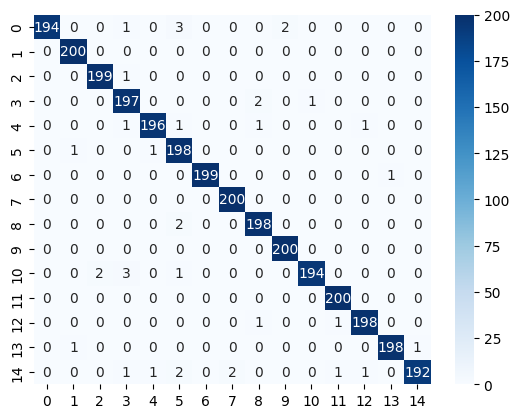

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

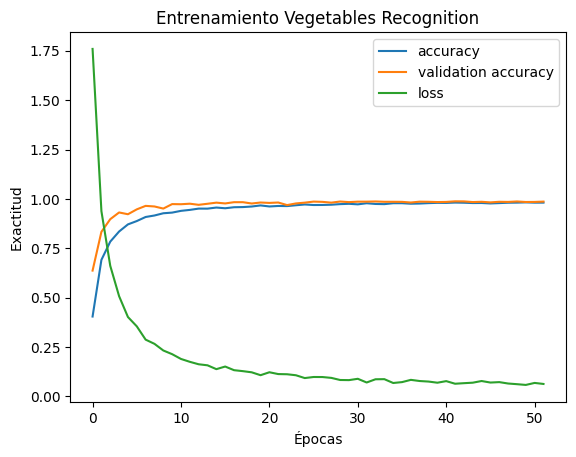

In [30]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Vegetables Recognition')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(150, 150, 3)
1/1 [==============================] - 0s 311ms/step
El vector de salida obtenido:  [[1.8008602e-30 1.2123793e-38 0.0000000e+00 0.0000000e+00 1.0000000e+00
  3.3841628e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.2877243e-22 0.0000000e+00 7.3764486e-35]]
1/1 [==============================] - 0s 20ms/step
La etiqueta de salida predicha es  4
1/1 [==============================] - 0s 20ms/step
Ahora dicho con texto: La etiqueta de salida predicha es  Brocoli


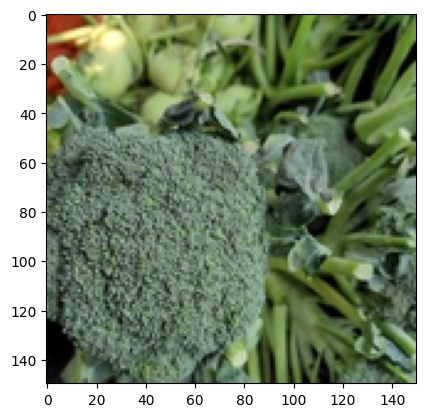

In [31]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Habichuelas', 'Calabaza amarga', 'Calabaza vinatera', 'Berenjena', 'Brocoli', 
           'Col', 'Pimiento', 'Zanahoria', 'Coliflor', 'Pepino',
           'Papaya', 'Papa', 'Calabaza', 'Rábano', 'Tomate']
%matplotlib inline

pil_im = Image.open('/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Broccoli/1002.jpg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])

In [32]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Habichuelas', 'Calabaza amarga', 'Calabaza vinatera', 'Berenjena', 'Brocoli', 
           'Col', 'Pimiento', 'Zanahoria', 'Coliflor', 'Pepino',
           'Papaya', 'Papa', 'Calabaza', 'Rábano', 'Tomate']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL
1/1 [==============================] - 0s 25ms/step
Pepino -> Pepino
Col -> Col
Habichuelas -> Habichuelas
Col -> Col
Rábano -> Rábano
Papa -> Papa
Col -> Col
Rábano -> Rábano
Tomate -> Tomate
Zanahoria -> Zanahoria
Pimiento -> Pimiento
Col -> Col
Calabaza amarga -> Calabaza amarga
Coliflor -> Coliflor
Pimiento -> Pimiento
Papaya -> Papaya
Zanahoria -> Zanahoria
Coliflor -> Coliflor
Rábano -> Rábano
Rábano -> Rábano
Coliflor -> Coliflor
Berenjena -> Berenjena
Habichuelas -> Habichuelas
Pimiento -> Pimiento
Pepino -> Pepino
Berenjena -> Berenjena
Papa -> Papa
Papa -> Papa
Calabaza vinatera -> Calabaza vinatera
Pimiento -> Pimiento
Brocoli -> Brocoli
Calabaza vinatera -> Calabaza vinatera
1/1 [==============================] - 0s 26ms/step
Col -> Col
Col -> Col
Col -> Col
Tomate -> Tomate
Col -> Col
Brocoli -> Brocoli
Zanahoria -> Zanahoria
Papaya -> Papaya
Papaya -> Papaya
Calabaza vinatera -> Calabaza vinatera
Zanahoria -> Zanahoria
Pimiento -> Pimien